<p style="font-family: Arial; font-size:2.0em;color:red;"> Alcohol Sales Forecast using RNN & LSTM </p> 

Alcohol sales data was collected from FRED Economic data source. It contains the sales of alcohol in the united states year wise. below is the snap shot of the website that contains the dataset. This small project will try to forecast sales of alcohol for the next 1 year using RNN and LSTM Deep Learning Method
![](eq2.png)

<p style="font-family: Arial; font-size:1.5em;color:blue;"> Libraries </p> 

In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Loading the directory
dir = r"C:\important_files\R&Python\UDEMY-TSA-FINAL\UDEMY_TSA_FINAL\Data"
os.chdir(dir)

<p style="font-family: Arial; font-size:1.5em;color:blue;"> Reading the dataset</p> 

In [7]:
# Loading the file by parsing dates as date and
# making date as the index column for the dataframe
# and setting the freq to MS
df= pd.read_csv('Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq='MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


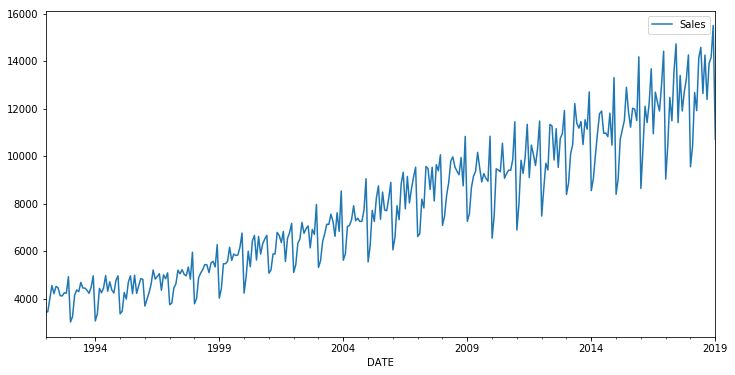

In [10]:
#Changing the column names 
df.columns=['Sales']

#Plotting the sales
df.plot(figsize=(12,6));

Looking at the above graph, it is clear that the sales have seasonality and trend. It can be more clear if the graph is
ETS decomposed into trend, seasonality and noise

<p style="font-family: Arial; font-size:1.5em;color:blue;"> Seasonality & ETS Decomposition </p> 
The statsmodels library provides an implementation of the naive, or classical, decomposition method in a function called seasonal_decompose(). It requires that you specify whether the model is additive or multiplicative. By default, ets decomposition assums additive model.

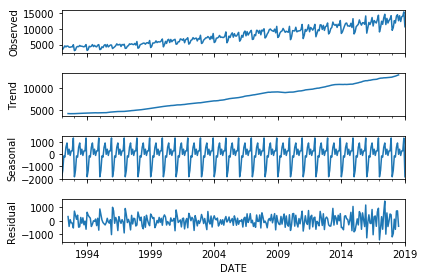

In [14]:
#ETS decomposition into trend, seasonality & residual 
seasonal_decompose(df['Sales']).plot();

Seasonality is quite evident from the above decomposition. Next train and test datasets are created to train a model and forcast the values for the next 1 year. Also, it is important to scale the dataset as there is difference in the range of the maximum values and neurons would be confused to get the right values for the weight and bais for the model as shown in the below trend

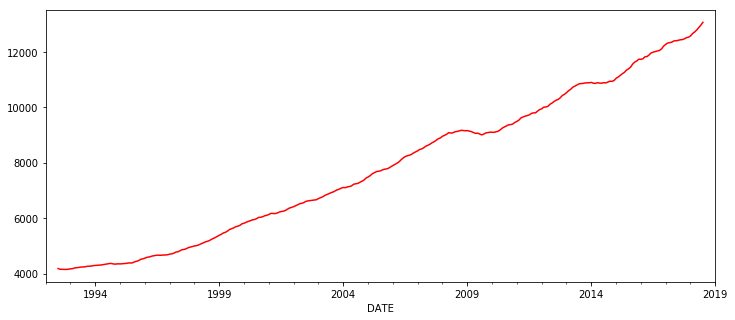

In [23]:
x=seasonal_decompose(df['Sales'])
x.trend.plot(figsize=(12,5),color='r');

In [16]:
# Creating test and train dataset
# If we want to predict for the next
# 1 year, then we will create the
# data set for the next 1 year
# len(df) = 325 and we can't divide
# dataset randomly

train = df.iloc[:313]
test = df.iloc[313:325]

In [27]:
# Standardizing the Sales for train
# and test datasets between 0 and 1

scaler=MinMaxScaler()
scaler.fit(train)
scl_train=scaler.transform(train)
scl_test=scaler.transform(test)

<p style="font-family: Arial; font-size:1.5em;color:blue;"> Time series generator & LSTM  </p> 

Time series data preparation : Time series data requires preparation before it can be used to train a supervised learning model, such as a deep learning model.A supervised learning algorithm requires that data is provided as a collection of samples, where each sample has an input component (X) and an output component (y).Keras provides the TimeseriesGenerator that can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.
![](eq1.png)
in the keras's time series generator, data set are divided into x number of batches and for y lags. so that for each layer dataset is made ready. For seasonal data, number of features should be 12 to capture all the data up the change of season over the year. smaller batch sizes lead to improve training

LSTM model is used to tackle the issue of shrinking gradient in RNN.LSTM predictions are always conditioned by the past experience of the network’s inputs
![](eq3.png)

In [45]:
#Finding testgenerator objects
generator= TimeseriesGenerator(scl_train,scl_train,length=12,batch_size=1)

In [43]:
# A sequential RNN model is built
# with a CNN layer with 100 neurons and
# a dense layer of 1 neuron to 
# aggregrate the results

model=Sequential()

#add neurons to LSTM Layer
model.add(LSTM(100,activation='relu',input_shape=(12,1))) 

#aggregate all neurons to single prediction
model.add(Dense(1))

#compile
model.compile(optimizer='adam',loss='mse')

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [46]:
# running the model with generator batches 
# and 25 epochs
model.fit_generator(generator,epochs=25)

Epoch 1/25
301/301 [==============================] - 5s 15ms/step - loss: 0.0162
Epoch 2/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0097
Epoch 3/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0093
Epoch 4/25
301/301 [==============================] - 4s 14ms/step - loss: 0.0091: 0s - loss: 
Epoch 5/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0074
Epoch 6/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0074
Epoch 7/25
301/301 [==============================] - 4s 15ms/step - loss: 0.0072
Epoch 8/25
301/301 [==============================] - 4s 14ms/step - loss: 0.0066: 0
Epoch 9/25
301/301 [==============================] - 4s 14ms/step - loss: 0.0053
Epoch 10/25
301/301 [==============================] - 4s 14ms/step - loss: 0.0038
Epoch 11/25
301/301 [==============================] - 4s 14ms/step - loss: 0.0031
Epoch 12/25
301/301 [==============================] - 4s 14ms/step - loss: 0.00

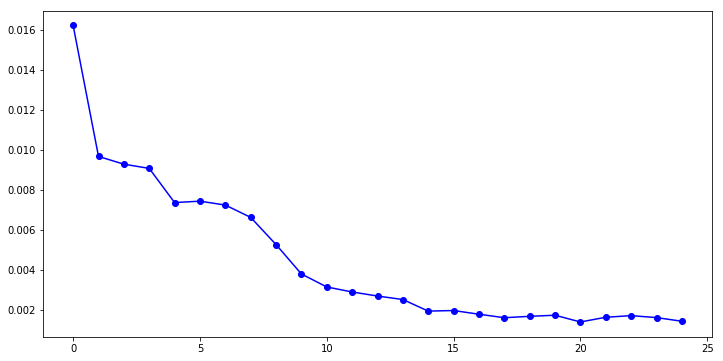

In [56]:
# Creating the loss graph
plt.figure(figsize=(12,6))
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss'],color='blue',marker='o',label=True);

# From the graph it is clear that
# loss starts decreasing for RNN-LSTM
# model and became constant after
# 15 epochs

<p style="font-family: Arial; font-size:1.5em;color:blue;"> Forecasting Sales </p> 

In [62]:
# Since model is train to see 12 history
# data to predict 1 data in future, to
# predict one test data, model need to
# evaluate last 12 history data

test_pred=[]
first_eval=scl_train[-12:] # last 12 points of the training dataset

# since the timeseriesgenerator object is 3-dimensional
current_eval=first_eval.reshape(1,12,1)

for i in range(len(test)):
    current_pred=model.predict(current_eval)[0]
    test_pred.append(current_pred)
    current_eval=np.append(current_eval[:,1:,],[[current_pred]],axis=1)

In [66]:
test_pred

[array([0.70355713], dtype=float32),
 array([0.8467064], dtype=float32),
 array([0.78802323], dtype=float32),
 array([0.963169], dtype=float32),
 array([1.0379938], dtype=float32),
 array([0.7786554], dtype=float32),
 array([0.93318355], dtype=float32),
 array([0.8106394], dtype=float32),
 array([0.88402927], dtype=float32),
 array([0.9293324], dtype=float32),
 array([0.9960296], dtype=float32),
 array([0.6214272], dtype=float32)]

In [70]:
# Inverting back the prediction to actual values
actual_pred = scaler.inverse_transform(test_pred)

#Adding back the predictions
test['predictions']=actual_pred

test

,Sales,predictions
DATE,,
2018-02-01,10415,11261.914907
2018-03-01,12683,12936.618061
2018-04-01,11919,12250.083808
2018-05-01,14138,14299.113882
2018-06-01,14583,15174.489334
2018-07-01,12640,12140.489639
2018-08-01,14257,13948.314361
2018-09-01,12396,12514.670123
2018-10-01,13914,13373.258421


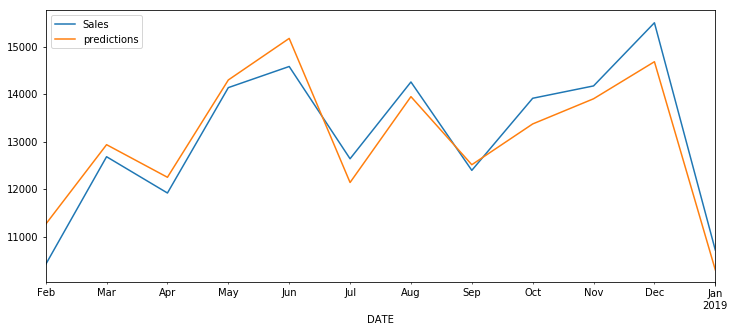

In [72]:
test.plot(figsize=(12,5));

 There is little bit of randomness, more or less, the predictions is close to the acutal values.  even decreasing epochs, close to 15, we can get the similar results.

In [75]:
mean_squared_error(test['predictions'],test['Sales'])

236547.107145299